In [81]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def determine_site_dist(map, depth, freq, info, depth_thres = 1):
    """For all sites, determine if they are fixed or polymorphic"""

    Dist = []
    for i in range(info.shape[0]):
        # Add samples IDs as map header and match samples
        # in map with samples in depth

        # Create site data frame
        site = map.copy()
        site['depth'] = depth.loc[ depth.index[i], map.index ]
        site['freq'] = freq.loc[ freq.index[i], map.index ]

        # Remove samples without information for site
        site = site[site.depth >= depth_thres]

        # Determine if it is polymorphic or fixed
        site_crosstab = pd.crosstab(site.freq >= 0.5, site.Group)
        if site_crosstab.shape == (2,2):
            if (np.matrix(site_crosstab).diagonal() == [0,0]).all() or (np.fliplr(np.matrix(site_crosstab)).diagonal() == [0, 0]).all():
                mutation_type = 'fixed'
            else:
                mutation_type = 'polymorphic'
        else:
            mutation_type = np.nan

        Dist.append(mutation_type)
    
    return(Dist)

In [3]:
def determine_mutation_effect(r):
    """Mini function for apply, takes a series and checks if the mutation
    is synonymous (s) or non-synonymopus (n)"""
    
    ii = r.loc[['count_a', 'count_c', 'count_g', 'count_t']] > 0
    aa = np.array(r.amino_acids.split(sep=','))

    if all(aa[ii][0] == aa[ii]):
        effect = 's'
    else:
        effect = 'n'

    return effect

In [4]:
def mktest_fisher_exact(g):
    """Per perform the fisher's exact test on a gene MK 
    contingency table."""
    
    tab = np.array([[g.Dn,g.Pn],[g.Ds,g.Ps]])
    oddsratio, pval = stats.fisher_exact(tab, alternative='two-sided')
    # oddsratio, pval = stats.fisher_exact(tab, alternative='greater')
    
    return pval

In [7]:
def read_and_process_data(map_file, info_file, depth_file, freqs_file,
                         groups, cov_thres=1):
    """Reads MIDAS output files, selects gene sites and samples above threshold,
    determines mutation effect (s or n) and makes sure files are consistent
    with each other"""
    
    # Read data
    info = pd.read_csv(info_file, sep="\t")
    depth = pd.read_csv(depth_file, sep="\t")
    freq = pd.read_csv(freqs_file, sep="\t")

    # Remove non gene sites
    ii = ~info.gene_id.isnull()
    info = info.loc[ii, :]
    depth = depth.loc[ii, :]
    freq = freq.loc[ii, :]

    # Remove site_id columns
    depth = depth.drop(axis=1, labels='site_id')
    freq = freq.drop(axis=1, labels='site_id')

    # subset for tests
    info = info.head(1000)
    depth = depth.head(1000)
    freq = freq.head(1000)

    # Determine effect of sites (this is constant and indepentent of samples)
    info['Effect'] = info.apply(determine_mutation_effect, axis=1)
    
    # Check that sample names match between freq and depth
    if not all(freq.columns == depth.columns):
        raise ValueError("Columns don't match between freq and depth files")

        
    # Read map file and select groups
    map = pd.read_csv(map_file, sep="\t")
    map.index = map.ID
    map = map.loc[map.Group.isin(groups),:].copy()
    
    # Remove samples from other groups
    ci = depth.columns.isin(map.ID)
    depth = depth.loc[:, ci]
    freq = freq.loc[:, ci]

    # Reorder map
    map = map.loc[depth.columns,:]

    # Calculate coverage in sites
    map['coverage'] = depth.mean(axis=0)

    # Remove samples below coverage
    ci = map.coverage >= cov_thres
    map = map.loc[ci, :]
    depth = depth.loc[:, map.index]
    freq = freq.loc[:, map.index]
    
    return map, freq, info, depth

In [6]:
def calculate_mk_oddsratio(map, info, depth, freq, depth_thres=1):
    """Determine if sites are fixed of polymorphic, calculate MK
    contingency table per gene, and calculate odds ratio"""
    
    if not all(map.index == depth.columns):
        raise ValueError("Samples in map and depth don't match")
    if not all(map.index == freq.columns):
        raise ValueError("Samples in map and freq don't match")
    if not all(freq.columns == depth.columns):
        raise ValueError("Samples in freq and depth don't match")

    # Determine type of mutation
    info['Type'] = determine_site_dist(map=map, depth=depth, freq=freq, info=info, depth_thres=depth_thres)
    
    # Calculate MK contingency table per gene
    Genes = pd.DataFrame(columns=['Gene', 'Dn', 'Ds', 'Pn', 'Ps'])
    for g in info.gene_id.unique():
        dat = info.loc[info.gene_id == g,:].copy()
        tab = pd.crosstab(dat.Effect, dat.Type, rownames=['Effect'], colnames=['Type'])
        tab = tab.reindex(index=pd.Index(['n','s']), columns=pd.Index(['fixed', 'polymorphic']), fill_value=0)
        s = pd.Series(g, index=['Gene']).append(tab.fixed).append(tab.polymorphic)
        Genes = Genes.append(pd.DataFrame([list(s)], columns=Genes.columns), ignore_index=True)
        
    # Calculate ratio
    np.seterr(divide='ignore', invalid='ignore')
    Genes['ratio'] = pd.to_numeric(Genes.Dn * Genes.Ps) / pd.to_numeric(Genes.Ds * Genes.Pn)
    np.seterr(divide='raise', invalid='raise')
    Genes.replace(np.inf, np.nan, inplace=True)
    # Genes['hg.pval'] = Genes.apply(mktest_fisher_exact, axis=1)
    # Genes.head()
    
    return Genes, info

In [8]:
map_file = "/home/sur/micropopgen/data/test_data/midas/map.txt"
depth_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_depth.txt"
info_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_info.txt"
freqs_file = "/home/sur/micropopgen/data/test_data/midas/merged.snps/Streptococcus_sp_60086/snps_freq.txt"
groups = ['Buccal mucosa', 'Tongue dorsum']
depth_thres = 1
cov_thres = 3
nperm = 99

In [9]:
map, freq, info, depth = read_and_process_data(map_file=map_file, info_file=info_file,
                                               depth_file=depth_file, freqs_file=freqs_file,
                                               groups=groups, cov_thres=cov_thres)
Genes, info = calculate_mk_oddsratio(map=map, info=info, depth=depth, freq=freq, depth_thres=depth_thres)

In [10]:
if nperm > 0:
    Perms = np.empty((Genes.shape[0], nperm + 1))
    Perms[:] = np.nan
    Perms[:, 0] = Genes.ratio
    np.random.seed(5)
    for i in range(1,nperm + 1):
        # print(i)
        map_i = map.copy()
        map_i['Group'] = np.random.permutation(map_i.Group)
        Genes_i, info_i = calculate_mk_oddsratio(map=map_i, info=info, depth=depth,
                                                 freq=freq, depth_thres=depth_thres)
        Perms[:, i] = Genes_i.ratio
    # Perms

    # Calculate permutation p-values
    Genes['nperm'] = nperm + 1 - pd.isnull(Perms).sum(axis=1)
    np.seterr(invalid='ignore', divide='ignore')
    Genes['P'] = np.greater_equal(Perms[: ,np.repeat(0 ,nperm + 1)],Perms).sum(axis=1) / Genes['nperm']
    np.seterr(invalid='raise', divide='raise')

Genes.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,         nan],
       [ 0.72727273,  0.        ,  0.        , ...,  0.72727273,
         0.90625   ,         nan],
       [ 1.06666667,  1.96825397,  1.96825397, ...,  1.06666667,
         1.36111111,  0.        ],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ...,         nan,
                nan,  0.        ]])

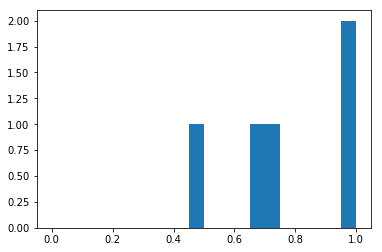

In [96]:
# Plot historgram of permutation p-values
plt.hist(Genes['P'][~pd.isnull(Genes.ratio)], bins=20, range=(0,1));

In [98]:
# Calculate hg #p-value for analysis
Genes['fisher_pval'] = Genes.apply(mktest_fisher_exact, axis=1)
# Genes

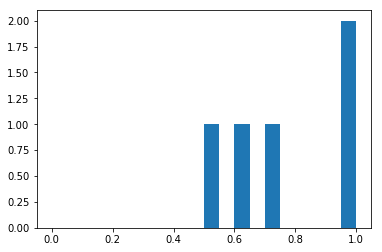

In [97]:
# Plot historgram of permutation p-values
plt.hist(Genes['fisher_pval'][~pd.isnull(Genes.ratio)], bins=20, range=(0, 1));

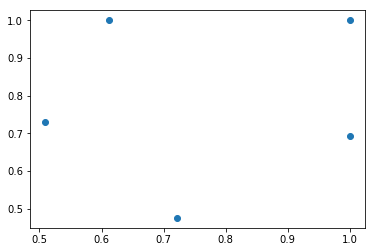

In [102]:
plt.plot(x=Genes['fisher_pval'][~pd.isnull(Genes.ratio)],y=Genes['P'][~pd.isnull(Genes.ratio)],"o",)

0    1.000000
1    0.722024
2    1.000000
3    0.612616
5    0.509556
Name: fisher_pval, dtype: float64

0    1.000000
1    0.475000
2    0.692308
3    1.000000
5    0.730769
Name: P, dtype: float64

In [73]:
plt.hist(Genes['P'][~pd.isnull(Genes.ratio) & Genes.Dn > 0], bins=20)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.475  ,  0.50125,  0.5275 ,  0.55375,  0.58   ,  0.60625,
         0.6325 ,  0.65875,  0.685  ,  0.71125,  0.7375 ,  0.76375,
         0.79   ,  0.81625,  0.8425 ,  0.86875,  0.895  ,  0.92125,
         0.9475 ,  0.97375,  1.     ]),
 <a list of 20 Patch objects>)

In [ ]:
%timeit np.matrix(site_crosstab)[:,::-1].diagonal()
%timeit np.fliplr(np.matrix(site_crosstab)).diagonal()